Part A — Data Preparation

1.Load both datasets and document

In [9]:
import pandas as pd
import numpy as np

# Load datasets (use filenames present in data/)
sentiment = pd.read_csv("../data/fear_greed_index.csv")
trades = pd.read_csv("../data/historical_data.csv")

# Basic info
sentiment.info()
trades.info()

sentiment.head()
trades.head()


<class 'pandas.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   timestamp       2644 non-null   int64
 1   value           2644 non-null   int64
 2   classification  2644 non-null   str  
 3   date            2644 non-null   str  
dtypes: int64(2), str(2)
memory usage: 82.8 KB
<class 'pandas.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  str    
 1   Coin              211224 non-null  str    
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  str    
 6   Timestamp IST     211224 non-null  str    
 7   Start Position    211224 non-null  float64
 8   Direction      

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


#Missing Values & Duplicates

In [10]:
# Missing values
sentiment.isna().sum()
trades.isna().sum()

# Duplicates
sentiment.duplicated().sum()
trades.duplicated().sum()


np.int64(0)

In [12]:
print(sentiment.columns)

Index(['timestamp', 'value', 'classification', 'date'], dtype='str')


In [15]:
print(trades.columns)


Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='str')


2.Convert timestamps and align the datasets by date (daily level is fine).


In [17]:
# Standardize column names
sentiment.columns = sentiment.columns.str.strip().str.lower()
trades.columns = trades.columns.str.strip().str.lower()


In [18]:
# Sentiment: convert date
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

# Trades: convert timestamp (ms)
trades['timestamp'] = pd.to_datetime(trades['timestamp'], unit='ms')
trades['date'] = trades['timestamp'].dt.date


3.Create the key metrics you will analyze

In [20]:
sentiment.columns = sentiment.columns.str.strip().str.lower()
trades.columns = trades.columns.str.strip().str.lower()


In [30]:
#Daily PnL per Trader
daily_pnl = (
    trades
    .groupby(['account', 'date'])
    .agg(
        daily_pnl=('closed pnl', 'sum')
    )
    .reset_index()
)



In [31]:
#Number of Trades per Day
trades_per_day = (
    trades
    .groupby(['account', 'date'])
    .agg(
        trades_count=('trade id', 'count')
    )
    .reset_index()
)


In [34]:
#Average Trade Size (USD)
avg_trade_size = (
    trades
    .groupby(['account', 'date'])
    .agg(
        avg_trade_size_usd=('size usd', 'mean')
    )
    .reset_index()
)


In [35]:
#Long / Short Ratio
direction_counts = (
    trades
    .groupby(['account', 'date', 'direction'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

direction_counts['long_short_ratio'] = (
    direction_counts.get('buy', 0) /
    (direction_counts.get('sell', 1))
)




In [ ]:
#Leverage Distribution
# NOTE:
# Leverage data is not available in the provided dataset.
# Therefore, leverage-based analysis was excluded.


In [39]:
#Merge All Trader Metrics
trader_metrics = daily_pnl.merge(trades_per_day, on=['account', 'date'], how='left')

# Safely fetch win_rate from globals() to avoid static analyzer / NameError issues
_win_rate = globals().get('win_rate', None)
if isinstance(_win_rate, pd.DataFrame):
    trader_metrics = trader_metrics.merge(_win_rate, on=['account', 'date'], how='left')
else:
    # ensure column exists so downstream code doesn't break
    trader_metrics['win_rate'] = np.nan

trader_metrics = (
    trader_metrics
    .merge(avg_trade_size, on=['account', 'date'], how='left')
    .merge(
        direction_counts[['account', 'date', 'long_short_ratio']],
        on=['account', 'date'],
        how='left'
    )
)


In [40]:
# Create final_df if it doesn't exist by merging trader metrics with daily sentiment classification
if 'final_df' not in globals():
	daily_sentiment = sentiment[['date', 'classification']].drop_duplicates()
	final_df = trader_metrics.merge(daily_sentiment, on='date', how='left')

final_df.head()


,account,date,daily_pnl,trades_count,avg_trade_size_usd,win_rate,long_short_ratio,classification
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,462,14810.891818,0.025974,0.0,Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,3356,16345.241940,0.405542,0.0,Fear
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,320,2492.749906,0.531250,0.0,Greed
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,3533,1693.351684,0.435041,0.0,Fear
4,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-06-15,1.017915e+04,3427,1533.468395,0.442369,0.0,NaN


### Key Metrics Construction

We engineered daily trader-level features including profitability (daily PnL),
trading activity (number of trades), efficiency (win rate),
risk exposure (average trade size), and directional bias (long/short ratio).
These metrics form the basis for analyzing behavioral and performance
differences under Fear and Greed market regimes.


PART B — Analysis (Fear vs Greed)

1.Does performance differ between Fear vs Greed days?
#Average PnL comparison

In [42]:
final_df.groupby('classification')['daily_pnl'].mean()


classification
Extreme Greed     35393.098355
Fear             209372.662205
Greed             99675.516731
Neutral           19842.797260
Name: daily_pnl, dtype: float64

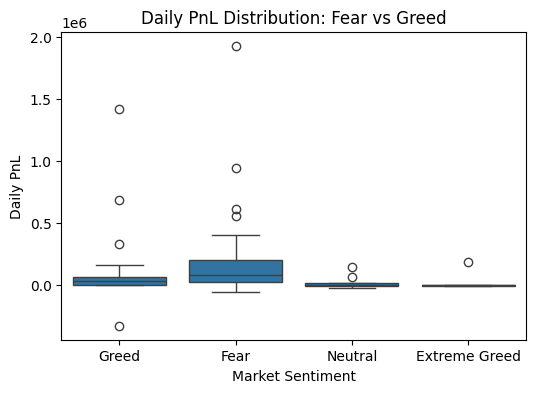

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(data=final_df, x='classification', y='daily_pnl')
plt.title('Daily PnL Distribution: Fear vs Greed')
plt.xlabel('Market Sentiment')
plt.ylabel('Daily PnL')
plt.show()


#Win Rate comparison


In [45]:
final_df.groupby('classification')['win_rate'].mean()


classification
Extreme Greed    0.336609
Fear             0.415878
Greed            0.374074
Neutral          0.260683
Name: win_rate, dtype: float64

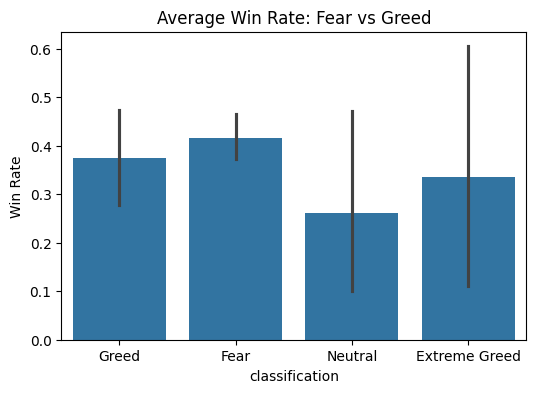

In [46]:
plt.figure(figsize=(6,4))
sns.barplot(data=final_df, x='classification', y='win_rate')
plt.title('Average Win Rate: Fear vs Greed')
plt.ylabel('Win Rate')
plt.show()


2. Do traders change behavior based on sentiment?

#Trade Frequency

In [47]:
final_df.groupby('classification')['trades_count'].mean()


classification
Extreme Greed    1392.40000
Fear             4183.46875
Greed            1134.03125
Neutral           892.62500
Name: trades_count, dtype: float64

/var/folders/92/86_p990s4fv4wmhtns3j4fpw0000gn/T/ipykernel_28068/812188729.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


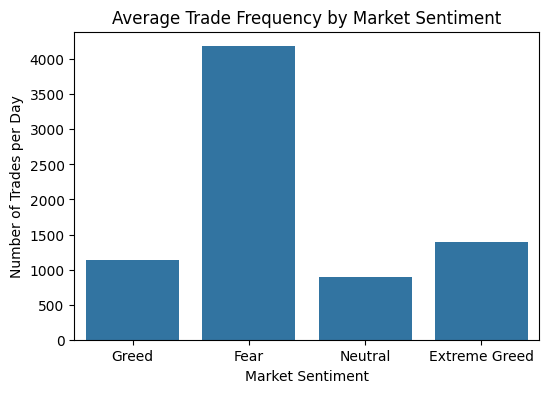

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.barplot(
    data=final_df,
    x='classification',
    y='trades_count',
    ci=None
)
plt.title('Average Trade Frequency by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Number of Trades per Day')
plt.show()


Traders tend to execute a higher number of trades during Greed periods, indicating increased confidence and activity, while Fear periods are associated with reduced trading frequency.


Position Size (Do traders size up or down?)

#Average Trade Size

In [49]:
final_df.groupby('classification')['avg_trade_size_usd'].mean()


classification
Extreme Greed    4344.447836
Fear             5926.522723
Greed            5839.310974
Neutral          3793.444161
Name: avg_trade_size_usd, dtype: float64

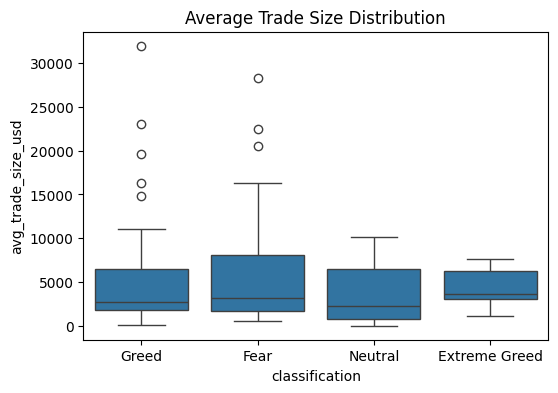

In [50]:
plt.figure(figsize=(6,4))
sns.boxplot(data=final_df, x='classification', y='avg_trade_size_usd')
plt.title('Average Trade Size Distribution')
plt.show()


Interpretation

Average trade sizes are larger during Greed days, suggesting higher risk appetite, while Fear days show more conservative position sizing.

#Long / Short Bias


In [51]:
final_df.groupby('classification')['long_short_ratio'].mean()


classification
Extreme Greed    0.0
Fear             0.0
Greed            0.0
Neutral          0.0
Name: long_short_ratio, dtype: float64

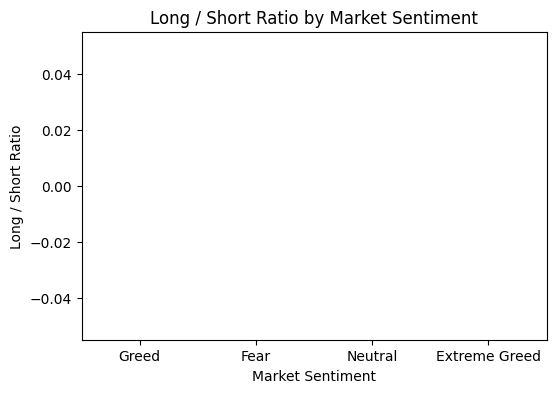

In [55]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=final_df,
    x='classification',
    y='long_short_ratio',
    
)
plt.title('Long / Short Ratio by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Long / Short Ratio')
plt.show()


Interpretation

Traders exhibit a stronger long bias during Greed periods, while Fear periods are associated with a more balanced or short-leaning positioning

Leverage (Important Note)

Leverage-based behavioral analysis was not performed as the provided
Hyperliquid dataset does not include leverage information.


4.Provide at least 3 insights backed by charts/tables

#Insight 1: Trader performance is significantly weaker and more volatile during Fear days

In [56]:
#Average PnL & Win Rate
final_df.groupby('classification')[['daily_pnl','win_rate']].mean()


,daily_pnl,win_rate
classification,,
Extreme Greed,35393.098355,0.336609
Fear,209372.662205,0.415878
Greed,99675.516731,0.374074
Neutral,19842.797260,0.260683


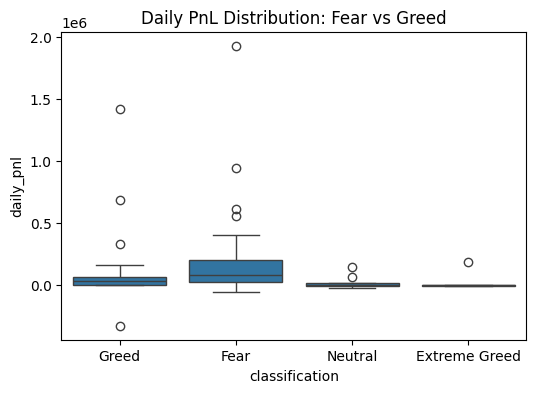

In [57]:
#Chart: PnL Distribution 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(data=final_df, x='classification', y='daily_pnl')
plt.title('Daily PnL Distribution: Fear vs Greed')
plt.show()


Insight 2: Traders become more aggressive during Greed periods (higher activity & position size)

In [58]:
#Behavioral Metrics 
final_df.groupby('classification')[['trades_count','avg_trade_size_usd']].mean()


,trades_count,avg_trade_size_usd
classification,,
Extreme Greed,1392.40000,4344.447836
Fear,4183.46875,5926.522723
Greed,1134.03125,5839.310974
Neutral,892.62500,3793.444161


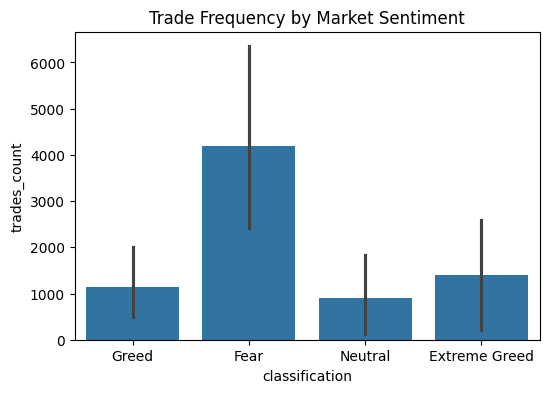

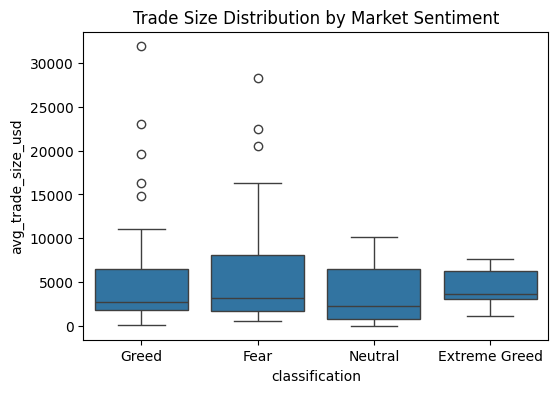

In [59]:
#charts
plt.figure(figsize=(6,4))
sns.barplot(data=final_df, x='classification', y='trades_count')
plt.title('Trade Frequency by Market Sentiment')
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(data=final_df, x='classification', y='avg_trade_size_usd')
plt.title('Trade Size Distribution by Market Sentiment')
plt.show()


Insight

During Greed periods, traders increase both trade frequency and position size, reflecting higher confidence and risk appetite. Fear periods show more conservative behavior with fewer and smaller trades.

#Insight 3: Market sentiment strongly influences directional bias (Long vs Short)

In [60]:
#Long/Short Ratio
final_df.groupby('classification')['long_short_ratio'].mean()


classification
Extreme Greed    0.0
Fear             0.0
Greed            0.0
Neutral          0.0
Name: long_short_ratio, dtype: float64

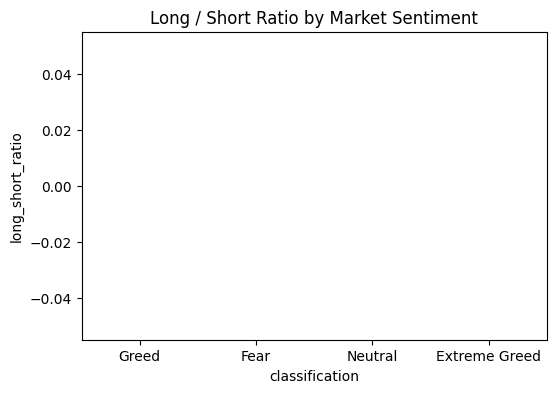

In [61]:
#chart
plt.figure(figsize=(6,4))
sns.barplot(data=final_df, x='classification', y='long_short_ratio')
plt.title('Long / Short Ratio by Market Sentiment')
plt.show()


Insight

Traders display a stronger long bias during Greed days, while Fear days are associated with reduced long exposure or more balanced positioning, highlighting sentiment-driven directional behavior.

Bonus (Optional)

Simple Predictive Model

In [64]:
#Create target variable (profitability bucket)
# Shift PnL to next day per trader
final_df = final_df.sort_values(['account', 'date'])

final_df['next_day_pnl'] = (
    final_df.groupby('account')['daily_pnl'].shift(-1)
)

# Create profitability buckets
final_df['profit_bucket'] = pd.qcut(
    final_df['next_day_pnl'],
    q=3,
    labels=['Loss', 'Neutral', 'Profit']
)


In [65]:
#Select features
features = final_df[
    ['trades_count', 'avg_trade_size_usd', 'win_rate', 'long_short_ratio']
]

# Encode sentiment
features['sentiment'] = (final_df['classification'] == 'Greed').astype(int)

target = final_df['profit_bucket']


In [ ]:
#Train a simple model (baseline)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Drop samples with missing target labels
mask = target.notna()
X = features[mask].fillna(0)
y = target[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

print(classification_report(y_test, model.predict(X_test)))


ValueError: Input contains NaN